# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [ ]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [ ]:
latent_dim = 16

encoder_inputs = keras.Input(shape=(112, 112, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 56, 56, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 32)           9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d_1[0][0]']            
                                                                                            

## Build the decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 56, 56, 32)        1846

## Define the VAE as a `Model` with a custom `train_step`

In [ ]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [ ]:
from __future__ import print_function
import os
import numpy as np
import cv2
import tensorflow.keras as keras
import random
from google.colab import drive
drive.mount('/content/drive/')


save_dir = os.path.join(os.getcwd(), 'saved_models')
emb_model_name = 'mxnet1k_emb_model.h5'


data_dir = 'datasets/'
ds_name = 'mxnet1k'
ds_arc_file = 'mxnet1k.zip'

img_width = 112
img_height = 112

def parse_cls_name_mxnet(fn):
    s = fn
    return s

def load_data_mxnet_dataset(data_path, max_per_person = 10):
    classes = []
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    print(data_path)

    dirnames = [fn for fn in os.listdir(data_path)]
    for dir in dirnames:
        x_cls_data = []
        y_cls_data = []
        #print(dir)

        cls_path = os.path.join(data_path, dir)
        fnames = [fn for fn in os.listdir(cls_path) if fn.endswith((".png",".jpg",".bmp"))]

        max_cnt = min(max_per_person, len(fnames))
        i = 0
        for fn in fnames:
            img = cv2.imread(os.path.join(cls_path, fn), 0) #gray
            img = cv2.resize(img,(img_width, img_height))
            cls_name = parse_cls_name_mxnet(dir)
            try:
                cls_ind = classes.index(cls_name)
            except:
                classes.append(cls_name)
                cls_ind = classes.index(cls_name)
            x_cls_data.append(img)
            y_cls_data.append(cls_ind)
            i += 1
            if i >= max_cnt:
                break

        x_train.extend(x_cls_data)
        y_train.extend(y_cls_data)

    x_data_np = np.asarray(x_train)
    x_data_np = np.expand_dims(x_data_np, axis=3)
    y_data_np = np.asarray(y_train)
    return x_data_np, y_data_np, classes


!pwd
!rm -rf $data_dir
!mkdir -p $data_dir
!cp /content/drive/My\ Drive/datasets/$ds_arc_file .

!unzip -q $ds_arc_file -d $data_dir


classes = []
x_train, y_train, classes = load_data_mxnet_dataset(os.path.join(data_dir, ds_name), 5)

num_classes = len(classes)

#plt.hist(y_test, num_classes)
#plt.show()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(num_classes,'classes')
print('y_train shape:', y_train.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
x_train = x_train.astype('float32')

x_train /= 255

Mounted at /content/drive/
/content
datasets/mxnet1k
x_train shape: (4988, 112, 112, 1)
4988 train samples
1000 classes
y_train shape: (4988,)


In [ ]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
39/39 [==============================] - 100s 2s/step - loss: 8661.8198 - reconstruction_loss: 8620.6494 - kl_loss: 0.8741
Epoch 2/10
39/39 [==============================] - 98s 3s/step - loss: 8368.3442 - reconstruction_loss: 8303.8184 - kl_loss: 18.1749
Epoch 3/10
39/39 [==============================] - 93s 2s/step - loss: 8234.3305 - reconstruction_loss: 8213.3213 - kl_loss: 18.5841
Epoch 4/10
39/39 [==============================] - 94s 2s/step - loss: 8179.5316 - reconstruction_loss: 8142.1587 - kl_loss: 22.1470
Epoch 5/10
39/39 [==============================] - 98s 3s/step - loss: 8152.5385 - reconstruction_loss: 8097.4336 - kl_loss: 21.5280
Epoch 6/10
39/39 [==============================] - 95s 2s/step - loss: 8095.6606 - reconstruction_loss: 8055.3237 - kl_loss: 20.9626
Epoch 7/10
39/39 [==============================] - 93s 2s/step - loss: 8053.9082 - reconstruction_loss: 8015.3560 - kl_loss: 21.0310
Epoch 8/10
39/39 [==============================] - 94s 2s/ste

## Display a grid of sampled digits

1/1 [==============================] - 0s 24ms/step


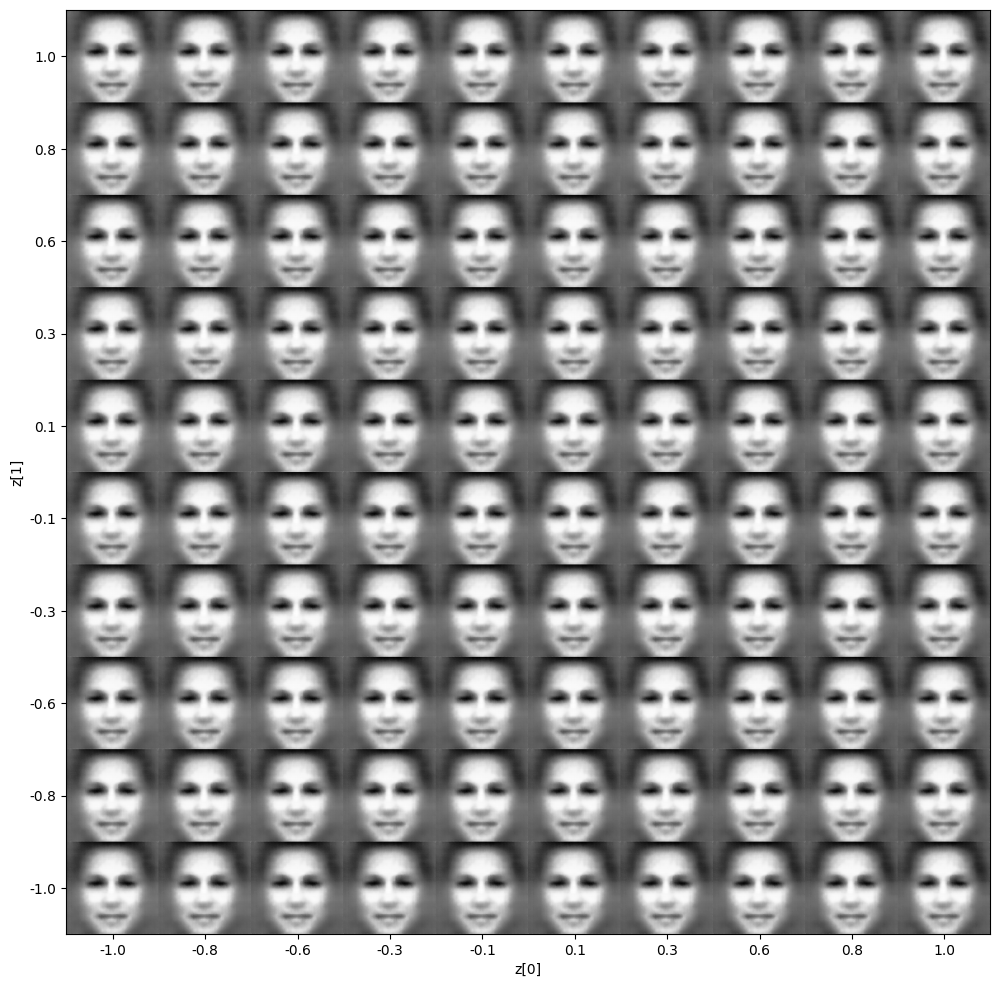

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=12):
    # display a n*n 2D manifold of digits
    img_size = 112
    scale = 1.0
    figure = np.zeros((img_size * n, img_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi, 0, 0, 0, 0, 0, 0]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size, img_size)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

In [ ]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)